# 필요한 모듈 import

In [1]:
import os
import random
import numpy as np
import pandas as pd
import seaborn as sns
import datetime as dt
import matplotlib.pyplot as plt
from datetime import datetime

from sklearn.preprocessing import LabelEncoder, StandardScaler, RobustScaler
from sklearn.metrics import accuracy_score, log_loss

import tensorflow as tf
from tensorflow.keras.utils import plot_model, to_categorical
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.callbacks import ReduceLROnPlateau, LearningRateScheduler
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras import layers


from sklearn import metrics
from sklearn import impute
from sklearn import preprocessing
from sklearn.utils import class_weight
from tensorflow import keras

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (10, 8)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 7)

In [2]:
# GPU 확인
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

2022-12-14 09:28:31.951053: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 9751973944141512869
 xla_global_id: -1,
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 24894767104
 locality {
   bus_id: 1
   links {
     link {
       device_id: 1
       type: "StreamExecutor"
       strength: 1
     }
   }
 }
 incarnation: 1028445432267412107
 physical_device_desc: "device: 0, name: Tesla V100-SXM2-32GB, pci bus id: 0000:00:05.0, compute capability: 7.0"
 xla_global_id: 416903419,
 name: "/device:GPU:1"
 device_type: "GPU"
 memory_limit: 69730304
 locality {
   bus_id: 1
   links {
     link {
       type: "StreamExecutor"
       strength: 1
     }
   }
 }
 incarnation: 10916703577342594823
 physical_device_desc: "device: 1, name: Tesla V100-SXM2-32GB, pci bus id: 0000:00:06.0, compute capability: 7.0"
 xla_global_id: 2144165316]

# 데이터 로드

In [3]:
train_df = pd.read_csv('./data/train.csv')
test_df = pd.read_csv('./data/test.csv')

/home/centos/anaconda3/envs/test_env/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3553: DtypeWarning: Columns (7) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [4]:
# 출력 시 생략되는 column이 없게 설정
pd.set_option('display.max_columns', None)

In [5]:
train_df

,id,target,home_team_name,away_team_name,match_date,league_name,league_id,is_cup,home_team_coach_id,away_team_coach_id,home_team_history_match_date_1,home_team_history_match_date_2,home_team_history_match_date_3,home_team_history_match_date_4,home_team_history_match_date_5,home_team_history_match_date_6,home_team_history_match_date_7,home_team_history_match_date_8,home_team_history_match_date_9,home_team_history_match_date_10,home_team_history_is_play_home_1,home_team_history_is_play_home_2,home_team_history_is_play_home_3,home_team_history_is_play_home_4,home_team_history_is_play_home_5,home_team_history_is_play_home_6,home_team_history_is_play_home_7,home_team_history_is_play_home_8,home_team_history_is_play_home_9,home_team_history_is_play_home_10,home_team_history_is_cup_1,home_team_history_is_cup_2,home_team_history_is_cup_3,home_team_history_is_cup_4,home_team_history_is_cup_5,home_team_history_is_cup_6,home_team_history_is_cup_7,home_team_history_is_cup_8,home_team_history_is_cup_9,home_team_history_is_cup_10,home_team_history_goal_1,home_team_history_goal_2,home_team_history_goal_3,home_team_history_goal_4,home_team_history_goal_5,home_team_history_goal_6,home_team_history_goal_7,home_team_history_goal_8,home_team_history_goal_9,home_team_history_goal_10,home_team_history_opponent_goal_1,home_team_history_opponent_goal_2,home_team_history_opponent_goal_3,home_team_history_opponent_goal_4,home_team_history_opponent_goal_5,home_team_history_opponent_goal_6,home_team_history_opponent_goal_7,home_team_history_opponent_goal_8,home_team_history_opponent_goal_9,home_team_history_opponent_goal_10,home_team_history_rating_1,home_team_history_rating_2,home_team_history_rating_3,home_team_history_rating_4,home_team_history_rating_5,home_team_history_rating_6,home_team_history_rating_7,home_team_history_rating_8,home_team_history_rating_9,home_team_history_rating_10,home_team_history_opponent_rating_1,home_team_history_opponent_rating_2,home_team_history_opponent_rating_3,home_team_history_opponent_rating_4,home_team_history_opponent_rating_5,home_team_history_opponent_rating_6,home_team_history_opponent_rating_7,home_team_history_opponent_rating_8,home_team_history_opponent_rating_9,home_team_history_opponent_rating_10,home_team_history_coach_1,home_team_history_coach_2,home_team_history_coach_3,home_team_history_coach_4,home_team_history_coach_5,home_team_history_coach_6,home_team_history_coach_7,home_team_history_coach_8,home_team_history_coach_9,home_team_history_coach_10,home_team_history_league_id_1,home_team_history_league_id_2,home_team_history_league_id_3,home_team_history_league_id_4,home_team_history_league_id_5,home_team_history_league_id_6,home_team_history_league_id_7,home_team_history_league_id_8,home_team_history_league_id_9,home_team_history_league_id_10,away_team_history_match_date_1,away_team_history_match_date_2,away_team_history_match_date_3,away_team_history_match_date_4,away_team_history_match_date_5,away_team_history_match_date_6,away_team_history_match_date_7,away_team_history_match_date_8,away_team_history_match_date_9,away_team_history_match_date_10,away_team_history_is_play_home_1,away_team_history_is_play_home_2,away_team_history_is_play_home_3,away_team_history_is_play_home_4,away_team_history_is_play_home_5,away_team_history_is_play_home_6,away_team_history_is_play_home_7,away_team_history_is_play_home_8,away_team_history_is_play_home_9,away_team_history_is_play_home_10,away_team_history_is_cup_1,away_team_history_is_cup_2,away_team_history_is_cup_3,away_team_history_is_cup_4,away_team_history_is_cup_5,away_team_history_is_cup_6,away_team_history_is_cup_7,away_team_history_is_cup_8,away_team_history_is_cup_9,away_team_history_is_cup_10,away_team_history_goal_1,away_team_history_goal_2,away_team_history_goal_3,away_team_history_goal_4,away_team_history_goal_5,away_team_history_goal_6,away_team_history_goal_7,away_team_history_goal_8,away_team_history_goal_9,away_team_history_goal_10,away_team_history_

In [6]:
test_df

,id,home_team_name,away_team_name,match_date,league_name,league_id,is_cup,home_team_coach_id,away_team_coach_id,home_team_history_match_date_1,home_team_history_match_date_2,home_team_history_match_date_3,home_team_history_match_date_4,home_team_history_match_date_5,home_team_history_match_date_6,home_team_history_match_date_7,home_team_history_match_date_8,home_team_history_match_date_9,home_team_history_match_date_10,home_team_history_is_play_home_1,home_team_history_is_play_home_2,home_team_history_is_play_home_3,home_team_history_is_play_home_4,home_team_history_is_play_home_5,home_team_history_is_play_home_6,home_team_history_is_play_home_7,home_team_history_is_play_home_8,home_team_history_is_play_home_9,home_team_history_is_play_home_10,home_team_history_is_cup_1,home_team_history_is_cup_2,home_team_history_is_cup_3,home_team_history_is_cup_4,home_team_history_is_cup_5,home_team_history_is_cup_6,home_team_history_is_cup_7,home_team_history_is_cup_8,home_team_history_is_cup_9,home_team_history_is_cup_10,home_team_history_goal_1,home_team_history_goal_2,home_team_history_goal_3,home_team_history_goal_4,home_team_history_goal_5,home_team_history_goal_6,home_team_history_goal_7,home_team_history_goal_8,home_team_history_goal_9,home_team_history_goal_10,home_team_history_opponent_goal_1,home_team_history_opponent_goal_2,home_team_history_opponent_goal_3,home_team_history_opponent_goal_4,home_team_history_opponent_goal_5,home_team_history_opponent_goal_6,home_team_history_opponent_goal_7,home_team_history_opponent_goal_8,home_team_history_opponent_goal_9,home_team_history_opponent_goal_10,home_team_history_rating_1,home_team_history_rating_2,home_team_history_rating_3,home_team_history_rating_4,home_team_history_rating_5,home_team_history_rating_6,home_team_history_rating_7,home_team_history_rating_8,home_team_history_rating_9,home_team_history_rating_10,home_team_history_opponent_rating_1,home_team_history_opponent_rating_2,home_team_history_opponent_rating_3,home_team_history_opponent_rating_4,home_team_history_opponent_rating_5,home_team_history_opponent_rating_6,home_team_history_opponent_rating_7,home_team_history_opponent_rating_8,home_team_history_opponent_rating_9,home_team_history_opponent_rating_10,home_team_history_coach_1,home_team_history_coach_2,home_team_history_coach_3,home_team_history_coach_4,home_team_history_coach_5,home_team_history_coach_6,home_team_history_coach_7,home_team_history_coach_8,home_team_history_coach_9,home_team_history_coach_10,home_team_history_league_id_1,home_team_history_league_id_2,home_team_history_league_id_3,home_team_history_league_id_4,home_team_history_league_id_5,home_team_history_league_id_6,home_team_history_league_id_7,home_team_history_league_id_8,home_team_history_league_id_9,home_team_history_league_id_10,away_team_history_match_date_1,away_team_history_match_date_2,away_team_history_match_date_3,away_team_history_match_date_4,away_team_history_match_date_5,away_team_history_match_date_6,away_team_history_match_date_7,away_team_history_match_date_8,away_team_history_match_date_9,away_team_history_match_date_10,away_team_history_is_play_home_1,away_team_history_is_play_home_2,away_team_history_is_play_home_3,away_team_history_is_play_home_4,away_team_history_is_play_home_5,away_team_history_is_play_home_6,away_team_history_is_play_home_7,away_team_history_is_play_home_8,away_team_history_is_play_home_9,away_team_history_is_play_home_10,away_team_history_is_cup_1,away_team_history_is_cup_2,away_team_history_is_cup_3,away_team_history_is_cup_4,away_team_history_is_cup_5,away_team_history_is_cup_6,away_team_history_is_cup_7,away_team_history_is_cup_8,away_team_history_is_cup_9,away_team_history_is_cup_10,away_team_history_goal_1,away_team_history_goal_2,away_team_history_goal_3,away_team_history_goal_4,away_team_history_goal_5,away_team_history_goal_6,away_team_history_goal_7,away_team_history_goal_8,away_team_history_goal_9,away_team_history_goal_10,away_team_history_opponen

# EDA

## 각 column명 및 데이터타입 파악

In [7]:
train_df.info(verbose=True, null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110938 entries, 0 to 110937
Data columns (total 190 columns):
 #    Column                                Non-Null Count   Dtype  
---   ------                                --------------   -----  
 0    id                                    110938 non-null  int64  
 1    target                                110938 non-null  object 
 2    home_team_name                        110937 non-null  object 
 3    away_team_name                        110937 non-null  object 
 4    match_date                            110938 non-null  object 
 5    league_name                           110937 non-null  object 
 6    league_id                             110938 non-null  int64  
 7    is_cup                                110937 non-null  object 
 8    home_team_coach_id                    89217 non-null   float64
 9    away_team_coach_id                    89123 non-null   float64
 10   home_team_history_match_date_1        109779 non-null 

/home/centos/anaconda3/envs/test_env/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: null_counts is deprecated. Use show_counts instead
  """Entry point for launching an IPython kernel.


In [8]:
test_df.info(verbose=True, null_counts=True)

/home/centos/anaconda3/envs/test_env/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: null_counts is deprecated. Use show_counts instead
  """Entry point for launching an IPython kernel.


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72711 entries, 0 to 72710
Data columns (total 189 columns):
 #    Column                                Non-Null Count  Dtype  
---   ------                                --------------  -----  
 0    id                                    72711 non-null  int64  
 1    home_team_name                        72711 non-null  object 
 2    away_team_name                        72711 non-null  object 
 3    match_date                            72711 non-null  object 
 4    league_name                           72711 non-null  object 
 5    league_id                             72711 non-null  int64  
 6    is_cup                                72711 non-null  bool   
 7    home_team_coach_id                    54135 non-null  float64
 8    away_team_coach_id                    54200 non-null  float64
 9    home_team_history_match_date_1        72213 non-null  object 
 10   home_team_history_match_date_2        71629 non-null  object 
 11   

## 각 column에 대한 설명  

### Descriptive columns  
- target: home, draw, away 3가지로 승부를 예측해야 하는 변수
- home_team_name: 홈 팀의 이름, train에는 실명이 있지만 test에는 *team home*으로 이름이 가려져 있음  
- away_team_name: 어웨이 팀의 이름, train에는 실명이 있지만 test에는 *team away*로 이름이 가려져 있음  
- match_date: 경기 날짜(UTC 그리니치 평균시 기준)
    - train: 2019-12-01 ~ 2021-05-01
    - test: 2021-05-01 ~ 2021-11-30
- league_name: 리그 이름
- league_id: 리그 id, 리그 이름이 같을 경우 구분할 수 있는 기준
- is_cup: 값이 1이면 컵 대회 경기임을 의미  
- home_team_coach_id: 홈 팀 코치의 id
- away_team_coach_id: 어웨이 팀 코치의 id  

### Historical columns  
Historical column들은 column명 안에 `history`를 키워드로 가지고 있으며, 1부터 10까지의 숫자로 인덱싱이 되어 해당 팀의 최근 10경기 동안의 데이터를 의미하고 있음. 1이 가장 최근의 경기, 10이 가장 오래된 경기를 의미. 과거의 경기들은 다른 리그에서 진행되었을 수도 있다는 점을 주의  

아래 feature 중 rating은 **Octosport**에서 측정한 것으로, rating 수치가 높은 팀이 낮은 팀을 이길 것이라고 예측할 수 있음  

**Historical home team features**  
- home_team_history_match_date_{i}: 홈 팀이 치른 지난 i번째 경기 날짜
- home_team_history_is_play_home_{i}: 값이 1인 경우 홈 팀이 자기 팀 구장에서 경기를 치렀다는 것을 의미  
- home_team_history_is_cup_{i}: 값이 1이면 컵 대회 경기였음을 의미  
- home_team_history_goal_{i}: 지난 i번째 경기에서 홈 팀이 넣은 골 수
- home_team_history_opponent_goal_{i}: 지난 i번째 경기에서 어웨이 팀이 넣은 골 수(=홈 팀이 실점한 골 수)
- home_team_history_rating_{i}: 지난 i번째 경기에서 홈 팀의 평점(pre match rating, 즉 경기 시작 전 평점) 
- home_team_history_opponent_rating_{i}: 지난 i번째 경기에서 어웨이 팀의 평점(pre match rating, 즉 경기 시작 전 평점) 
- home_team_history_coach_{i}: 지난 i번째 경기에서 홈 팀 코치의 id
- home_team_history_league_id_{i}: 지난 i번째 경기가 치러진 리그 id  

**Historical away team features**  
- away_team_history_match_date_{i}: 어웨이 팀이 치른 지난 i번째 경기 날짜
- away_team_history_is_play_home_{i}: 값이 1인 경우 어웨이 팀이 자기 팀 구장에서 경기를 치렀다는 것을 의미  
- away_team_history_is_cup_{i}: 값이 1이면 컵 대회 경기였음을 의미  
- away_team_history_goal_{i}: 지난 i번째 경기에서 어웨이 팀이 넣은 골 수
- away_team_history_opponent_goal_{i}: 지난 i번째 경기에서 홈 팀이 넣은 골 수(= 어웨이 팀이 실점한 골 수)
- away_team_history_rating_{i}: 지난 i번째 경기에서  어웨이 팀의 평점(pre match rating, 즉 경기 시작 전 평점) 
- away_team_history_opponent_rating_{i}: 지난 i번째 경기에서 홈 팀의 평점(pre match rating, 즉 경기 시작 전 평점) 
- away_team_history_coach_{i}: 지난 i번째 경기에서  어웨이 팀 코치의 id
- away_team_history_league_id_{i}: 지난 i번째 경기가 치러진 리그 id

## 결측치 확인

In [9]:
# 출력 시 생략되는 데이터가 없게 설정
pd.set_option('display.max_rows', None)

In [10]:
# train 데이터의 결측 확인

train_df.isnull().sum().sort_values(ascending=False)

away_team_history_coach_10              27129
home_team_history_coach_10              26653
away_team_history_coach_9               26150
home_team_history_coach_9               25733
away_team_history_coach_8               25219
home_team_history_coach_8               24869
away_team_history_coach_7               24377
home_team_history_coach_7               23980
away_team_history_coach_6               23525
home_team_history_coach_6               23258
away_team_history_coach_5               22855
home_team_history_coach_5               22602
away_team_history_coach_4               22294
home_team_history_coach_4               22118
away_team_history_coach_3               21949
away_team_coach_id                      21815
home_team_history_coach_3               21733
home_team_coach_id                      21721
away_team_history_coach_2               21696
away_team_history_coach_1               21641
home_team_history_coach_2               21571
home_team_history_coach_1         

In [11]:
# test 데이터의 결측 확인

test_df.isnull().sum().sort_values(ascending=False)

away_team_history_coach_10              21289
home_team_history_coach_10              21260
away_team_history_coach_9               20997
home_team_history_coach_9               20996
away_team_history_coach_8               20728
home_team_history_coach_8               20703
away_team_history_coach_7               20450
home_team_history_coach_7               20438
away_team_history_coach_6               20177
home_team_history_coach_6               20149
home_team_history_coach_5               19882
away_team_history_coach_5               19866
home_team_history_coach_4               19596
away_team_history_coach_4               19562
home_team_history_coach_3               19311
away_team_history_coach_3               19284
home_team_history_coach_2               19036
away_team_history_coach_2               19023
home_team_history_coach_1               18784
away_team_history_coach_1               18776
home_team_coach_id                      18576
away_team_coach_id                

각 column에 들어있는 결측이 전체 데이터에서 몇 %를 차지하는지 시각화:

In [12]:
all_null = pd.concat([
    (train_df.isna().sum(axis=0) / train_df.shape[0] * 100).rename('Train % Null'),
    (test_df.isna().sum(axis=0) / test_df.shape[0] * 100).rename('Test % Null')],
axis=1).sort_values(['Train % Null', 'Test % Null'], ascending=False)

all_null.style.background_gradient()

,Train % Null,Test % Null
away_team_history_coach_10,24.454200,29.278926
home_team_history_coach_10,24.025131,29.239042
away_team_history_coach_9,23.571725,28.877336
home_team_history_coach_9,23.195839,28.875961
away_team_history_coach_8,22.732517,28.507379
home_team_history_coach_8,22.417026,28.472996
away_team_history_coach_7,21.973535,28.125043
home_team_history_coach_7,21.615677,28.108539
away_team_history_coach_6,21.205538,27.749584
home_team_history_coach_6,20.964863,27.711075


In [13]:
# 퍼센트 말고 개수로도 확인

all_null = pd.concat([
    (train_df.loc[:, train_df.columns != 'target'].isna().sum(axis=0)).rename('Train num_Null'),
    (test_df.isna().sum(axis=0)).rename('Test num_Null')],
axis=1).sort_values(['Train num_Null', 'Test num_Null'], ascending=False)

all_null.style.background_gradient()

,Train num_Null,Test num_Null
away_team_history_coach_10,27129,21289
home_team_history_coach_10,26653,21260
away_team_history_coach_9,26150,20997
home_team_history_coach_9,25733,20996
away_team_history_coach_8,25219,20728
home_team_history_coach_8,24869,20703
away_team_history_coach_7,24377,20450
home_team_history_coach_7,23980,20438
away_team_history_coach_6,23525,20177
home_team_history_coach_6,23258,20149


전체적으로 위 결과를 보면 coach와 관련된 정보에 유독 결측값이 집중되어 있음을 알 수 있음  
이 column들이 target과의 상관관계도 적다면 아예 이 column들을 제거하는 쪽으로 시도 

In [14]:
# target만 따로 뗴어내어 정수로 변환
train_y = train_df['target'].copy()
train_y.head()

0    away
1    home
2    draw
3    away
4    home
Name: target, dtype: object

In [15]:
train_y.replace('home', 0, inplace=True)
train_y.replace('away', 1, inplace=True)
train_y.replace('draw', 2, inplace=True)

train_y.head()

0    1
1    0
2    2
3    1
4    0
Name: target, dtype: int64

['home_team_history_coach_1', 'home_team_history_coach_2', 'home_team_history_coach_3', 'home_team_history_coach_4', 'home_team_history_coach_5', 'home_team_history_coach_6', 'home_team_history_coach_7', 'home_team_history_coach_8', 'home_team_history_coach_9', 'home_team_history_coach_10']


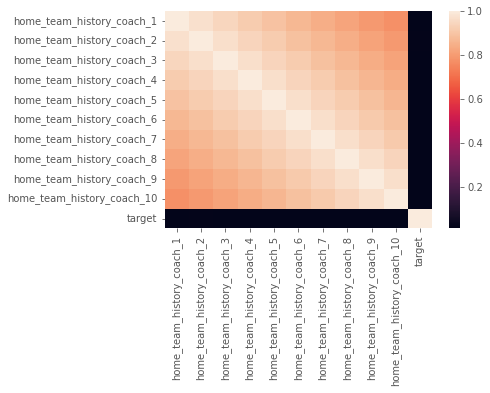

0 home_team_history_coach_4 0.009222503907133391
1 home_team_history_coach_5 0.010128204246449182
2 home_team_history_coach_9 0.010358838684884688
3 home_team_history_coach_6 0.010485894889174518
4 home_team_history_coach_8 0.010571751159559842
5 home_team_history_coach_3 0.010758368757967098
6 home_team_history_coach_7 0.011049583072237185
7 home_team_history_coach_10 0.011600350999702658
8 home_team_history_coach_1 0.01178113465909964
9 home_team_history_coach_2 0.013195021844153344


In [16]:
# home_team_history_coach와 target의 상관관계
target_columns = 'home_team_history_coach'

cols = []
for col in train_df.filter(regex=target_columns, axis=1).columns:
    cols.append(col)
print(cols)

corr = pd.concat([train_df[cols], train_y], axis=1).corr()
sns.heatmap(corr)
plt.show()

# home_team_history_coach와 target의 상관계수 출력
for idx, (k,v) in enumerate(corr['target'][:-1].sort_values().items()):
    print(idx, k, v)

['away_team_history_coach_1', 'away_team_history_coach_2', 'away_team_history_coach_3', 'away_team_history_coach_4', 'away_team_history_coach_5', 'away_team_history_coach_6', 'away_team_history_coach_7', 'away_team_history_coach_8', 'away_team_history_coach_9', 'away_team_history_coach_10']


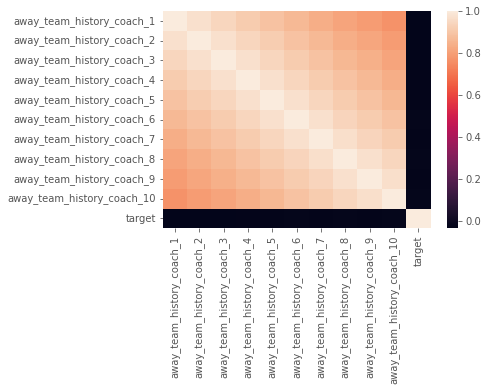

0 away_team_history_coach_1 -0.035995426010722656
1 away_team_history_coach_2 -0.03568555036962875
2 away_team_history_coach_3 -0.034332144808602874
3 away_team_history_coach_4 -0.030724161164175392
4 away_team_history_coach_5 -0.029979221283470473
5 away_team_history_coach_9 -0.029080542853597523
6 away_team_history_coach_7 -0.028414226139611323
7 away_team_history_coach_6 -0.027773516176536756
8 away_team_history_coach_8 -0.02775038668417833
9 away_team_history_coach_10 -0.025418977301686962


In [17]:
# away_team_history_coach와 target의 상관관계
target_columns = 'away_team_history_coach'

cols = []
for col in train_df.filter(regex=target_columns, axis=1).columns:
    cols.append(col)
print(cols)

corr = pd.concat([train_df[cols], train_y], axis=1).corr()
sns.heatmap(corr)
plt.show()

for idx, (k,v) in enumerate(corr['target'][:-1].sort_values().items()):
    print(idx, k, v)

['home_team_history_match_date_1', 'home_team_history_match_date_2', 'home_team_history_match_date_3', 'home_team_history_match_date_4', 'home_team_history_match_date_5', 'home_team_history_match_date_6', 'home_team_history_match_date_7', 'home_team_history_match_date_8', 'home_team_history_match_date_9', 'home_team_history_match_date_10', 'home_team_history_is_play_home_1', 'home_team_history_is_play_home_2', 'home_team_history_is_play_home_3', 'home_team_history_is_play_home_4', 'home_team_history_is_play_home_5', 'home_team_history_is_play_home_6', 'home_team_history_is_play_home_7', 'home_team_history_is_play_home_8', 'home_team_history_is_play_home_9', 'home_team_history_is_play_home_10', 'home_team_history_is_cup_1', 'home_team_history_is_cup_2', 'home_team_history_is_cup_3', 'home_team_history_is_cup_4', 'home_team_history_is_cup_5', 'home_team_history_is_cup_6', 'home_team_history_is_cup_7', 'home_team_history_is_cup_8', 'home_team_history_is_cup_9', 'home_team_history_is_cup_1

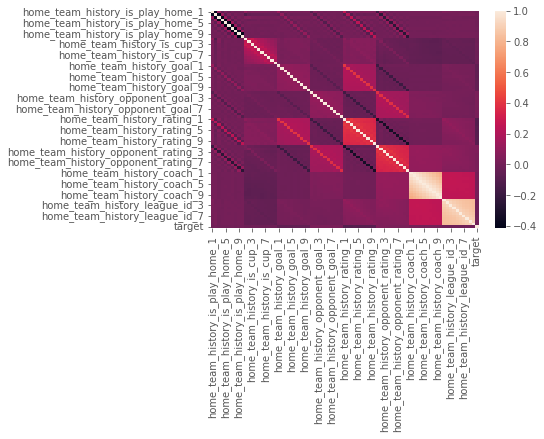

0 home_team_history_is_play_home_7 6.734560415204683e-05
1 home_team_history_is_play_home_5 0.0008195755611994607
2 home_team_history_is_play_home_4 0.0017128275073621205
3 home_team_history_is_play_home_9 0.0023290077907311846
4 home_team_history_is_play_home_10 0.0032389230834247358
5 home_team_history_is_play_home_2 0.004491761099038679
6 home_team_history_is_play_home_6 0.005801051826419543
7 home_team_history_is_play_home_8 0.007109558754307886
8 home_team_history_is_play_home_3 0.007609372977803365
9 home_team_history_coach_4 0.009222503907133391
10 home_team_history_league_id_10 0.009427572784460957
11 home_team_history_league_id_8 0.009726679469991192
12 home_team_history_is_play_home_1 0.009733134275717929
13 home_team_history_league_id_9 0.010012121320074284
14 home_team_history_coach_5 0.010128204246449182
15 home_team_history_coach_9 0.010358838684884688
16 home_team_history_coach_6 0.010485894889174518
17 home_team_history_coach_8 0.010571751159559842
18 home_team_history_

In [18]:
# 다른 home_team_history 관련 column들도 상관계수가 작은지 확인

target_columns = 'home_team_history'

cols = []
for col in train_df.filter(regex=target_columns, axis=1).columns:
    cols.append(col)
print(cols)

corr = pd.concat([train_df[cols], train_y], axis=1).corr()
sns.heatmap(corr)
plt.show()

for idx, (k,v) in enumerate(np.abs(corr['target'][:-1]).sort_values().items()):
    print(idx, k, v)

### 중간 판단
원래는 상관계수도 매우 작아서 coach 관련 column을 모두 제거하려 했으나, 다른 home_team_history 관련 column들도 상관계수가 0.11을 넘는 것이 없었기 때문에 그냥 삭제하면 안될 것 같아 보류하였음.  
추후 아예 다른 변수를 만드는데 사용하는 쪽으로 활용 모색

# Preprocessing

## 1. 날짜 관련 column 데이터타입 변경

In [19]:
# 변경 전: train

train_df.info(verbose=True, null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110938 entries, 0 to 110937
Data columns (total 190 columns):
 #    Column                                Non-Null Count   Dtype  
---   ------                                --------------   -----  
 0    id                                    110938 non-null  int64  
 1    target                                110938 non-null  object 
 2    home_team_name                        110937 non-null  object 
 3    away_team_name                        110937 non-null  object 
 4    match_date                            110938 non-null  object 
 5    league_name                           110937 non-null  object 
 6    league_id                             110938 non-null  int64  
 7    is_cup                                110937 non-null  object 
 8    home_team_coach_id                    89217 non-null   float64
 9    away_team_coach_id                    89123 non-null   float64
 10   home_team_history_match_date_1        109779 non-null 

/home/centos/anaconda3/envs/test_env/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: null_counts is deprecated. Use show_counts instead
  This is separate from the ipykernel package so we can avoid doing imports until


In [20]:
# 변경 전: test

test_df.info(verbose=True, null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72711 entries, 0 to 72710
Data columns (total 189 columns):
 #    Column                                Non-Null Count  Dtype  
---   ------                                --------------  -----  
 0    id                                    72711 non-null  int64  
 1    home_team_name                        72711 non-null  object 
 2    away_team_name                        72711 non-null  object 
 3    match_date                            72711 non-null  object 
 4    league_name                           72711 non-null  object 
 5    league_id                             72711 non-null  int64  
 6    is_cup                                72711 non-null  bool   
 7    home_team_coach_id                    54135 non-null  float64
 8    away_team_coach_id                    54200 non-null  float64
 9    home_team_history_match_date_1        72213 non-null  object 
 10   home_team_history_match_date_2        71629 non-null  object 
 11   

/home/centos/anaconda3/envs/test_env/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: null_counts is deprecated. Use show_counts instead
  This is separate from the ipykernel package so we can avoid doing imports until


In [21]:
for col in train_df.filter(regex='date', axis=1).columns:
    train_df[col] = pd.to_datetime(train_df[col])
    test_df[col] = pd.to_datetime(test_df[col])

In [22]:
# 변경 후: train

train_df.info(verbose=True, null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110938 entries, 0 to 110937
Data columns (total 190 columns):
 #    Column                                Non-Null Count   Dtype         
---   ------                                --------------   -----         
 0    id                                    110938 non-null  int64         
 1    target                                110938 non-null  object        
 2    home_team_name                        110937 non-null  object        
 3    away_team_name                        110937 non-null  object        
 4    match_date                            110938 non-null  datetime64[ns]
 5    league_name                           110937 non-null  object        
 6    league_id                             110938 non-null  int64         
 7    is_cup                                110937 non-null  object        
 8    home_team_coach_id                    89217 non-null   float64       
 9    away_team_coach_id                    89123 no

/home/centos/anaconda3/envs/test_env/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: null_counts is deprecated. Use show_counts instead
  This is separate from the ipykernel package so we can avoid doing imports until


In [23]:
# 변경 후: test

test_df.info(verbose=True, null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72711 entries, 0 to 72710
Data columns (total 189 columns):
 #    Column                                Non-Null Count  Dtype         
---   ------                                --------------  -----         
 0    id                                    72711 non-null  int64         
 1    home_team_name                        72711 non-null  object        
 2    away_team_name                        72711 non-null  object        
 3    match_date                            72711 non-null  datetime64[ns]
 4    league_name                           72711 non-null  object        
 5    league_id                             72711 non-null  int64         
 6    is_cup                                72711 non-null  bool          
 7    home_team_coach_id                    54135 non-null  float64       
 8    away_team_coach_id                    54200 non-null  float64       
 9    home_team_history_match_date_1        72213 non-null  datet

/home/centos/anaconda3/envs/test_env/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: null_counts is deprecated. Use show_counts instead
  This is separate from the ipykernel package so we can avoid doing imports until


## 2. feature engineering

### 날짜 기반 feature 생성:

In [24]:
# 생성 전
print(train_df.shape, test_df.shape)

(110938, 190) (72711, 189)


In [25]:
for i in range(1,11):
    train_df[f'home_team_history_match_days_ago_{i}'] = (train_df['match_date'] - train_df[f'home_team_history_match_date_{i}']).dt.days
    train_df[f'away_team_history_match_days_ago_{i}'] = (train_df['match_date'] - train_df[f'away_team_history_match_date_{i}']).dt.days
    test_df[f'home_team_history_match_days_ago_{i}'] = (test_df['match_date'] - test_df[f'home_team_history_match_date_{i}']).dt.days
    test_df[f'away_team_history_match_days_ago_{i}'] = (test_df['match_date'] - test_df[f'away_team_history_match_date_{i}']).dt.days

In [26]:
# 생성 후
print(train_df.shape, test_df.shape)

(110938, 210) (72711, 209)


에러 발생 가능성이 있는 경기 제거:

In [27]:
# 홈과 어웨이 팀의 이름이 같은 데이터

train_df[train_df['home_team_name'] == train_df['away_team_name']]

,id,target,home_team_name,away_team_name,match_date,league_name,league_id,is_cup,home_team_coach_id,away_team_coach_id,home_team_history_match_date_1,home_team_history_match_date_2,home_team_history_match_date_3,home_team_history_match_date_4,home_team_history_match_date_5,home_team_history_match_date_6,home_team_history_match_date_7,home_team_history_match_date_8,home_team_history_match_date_9,home_team_history_match_date_10,home_team_history_is_play_home_1,home_team_history_is_play_home_2,home_team_history_is_play_home_3,home_team_history_is_play_home_4,home_team_history_is_play_home_5,home_team_history_is_play_home_6,home_team_history_is_play_home_7,home_team_history_is_play_home_8,home_team_history_is_play_home_9,home_team_history_is_play_home_10,home_team_history_is_cup_1,home_team_history_is_cup_2,home_team_history_is_cup_3,home_team_history_is_cup_4,home_team_history_is_cup_5,home_team_history_is_cup_6,home_team_history_is_cup_7,home_team_history_is_cup_8,home_team_history_is_cup_9,home_team_history_is_cup_10,home_team_history_goal_1,home_team_history_goal_2,home_team_history_goal_3,home_team_history_goal_4,home_team_history_goal_5,home_team_history_goal_6,home_team_history_goal_7,home_team_history_goal_8,home_team_history_goal_9,home_team_history_goal_10,home_team_history_opponent_goal_1,home_team_history_opponent_goal_2,home_team_history_opponent_goal_3,home_team_history_opponent_goal_4,home_team_history_opponent_goal_5,home_team_history_opponent_goal_6,home_team_history_opponent_goal_7,home_team_history_opponent_goal_8,home_team_history_opponent_goal_9,home_team_history_opponent_goal_10,home_team_history_rating_1,home_team_history_rating_2,home_team_history_rating_3,home_team_history_rating_4,home_team_history_rating_5,home_team_history_rating_6,home_team_history_rating_7,home_team_history_rating_8,home_team_history_rating_9,home_team_history_rating_10,home_team_history_opponent_rating_1,home_team_history_opponent_rating_2,home_team_history_opponent_rating_3,home_team_history_opponent_rating_4,home_team_history_opponent_rating_5,home_team_history_opponent_rating_6,home_team_history_opponent_rating_7,home_team_history_opponent_rating_8,home_team_history_opponent_rating_9,home_team_history_opponent_rating_10,home_team_history_coach_1,home_team_history_coach_2,home_team_history_coach_3,home_team_history_coach_4,home_team_history_coach_5,home_team_history_coach_6,home_team_history_coach_7,home_team_history_coach_8,home_team_history_coach_9,home_team_history_coach_10,home_team_history_league_id_1,home_team_history_league_id_2,home_team_history_league_id_3,home_team_history_league_id_4,home_team_history_league_id_5,home_team_history_league_id_6,home_team_history_league_id_7,home_team_history_league_id_8,home_team_history_league_id_9,home_team_history_league_id_10,away_team_history_match_date_1,away_team_history_match_date_2,away_team_history_match_date_3,away_team_history_match_date_4,away_team_history_match_date_5,away_team_history_match_date_6,away_team_history_match_date_7,away_team_history_match_date_8,away_team_history_match_date_9,away_team_history_match_date_10,away_team_history_is_play_home_1,away_team_history_is_play_home_2,away_team_history_is_play_home_3,away_team_history_is_play_home_4,away_team_history_is_play_home_5,away_team_history_is_play_home_6,away_team_history_is_play_home_7,away_team_history_is_play_home_8,away_team_history_is_play_home_9,away_team_history_is_play_home_10,away_team_history_is_cup_1,away_team_history_is_cup_2,away_team_history_is_cup_3,away_team_history_is_cup_4,away_team_history_is_cup_5,away_team_history_is_cup_6,away_team_history_is_cup_7,away_team_history_is_cup_8,away_team_history_is_cup_9,away_team_history_is_cup_10,away_team_history_goal_1,away_team_history_goal_2,away_team_history_goal_3,away_team_history_goal_4,away_team_history_goal_5,away_team_history_goal_6,away_team_history_goal_7,away_team_history_goal_8,away_team_history_goal_9,away_team_history_goal_10,away_team_history_

In [28]:
# 변경 전
train_df.shape

(110938, 210)

In [29]:
# 홈과 어웨이 팀의 이름이 같은 데이터 행 제거

train_df = train_df[train_df['home_team_name'] != train_df['away_team_name']].reset_index(drop=True)

In [30]:
# 변경 후
train_df.shape

(110936, 210)

In [31]:
# train 확인
train_df.info(verbose=True, null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110936 entries, 0 to 110935
Data columns (total 210 columns):
 #    Column                                Non-Null Count   Dtype         
---   ------                                --------------   -----         
 0    id                                    110936 non-null  int64         
 1    target                                110936 non-null  object        
 2    home_team_name                        110935 non-null  object        
 3    away_team_name                        110935 non-null  object        
 4    match_date                            110936 non-null  datetime64[ns]
 5    league_name                           110935 non-null  object        
 6    league_id                             110936 non-null  int64         
 7    is_cup                                110935 non-null  object        
 8    home_team_coach_id                    89216 non-null   float64       
 9    away_team_coach_id                    89122 no

/home/centos/anaconda3/envs/test_env/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: null_counts is deprecated. Use show_counts instead
  


In [32]:
# test 확인
test_df.info(verbose=True, null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72711 entries, 0 to 72710
Data columns (total 209 columns):
 #    Column                                Non-Null Count  Dtype         
---   ------                                --------------  -----         
 0    id                                    72711 non-null  int64         
 1    home_team_name                        72711 non-null  object        
 2    away_team_name                        72711 non-null  object        
 3    match_date                            72711 non-null  datetime64[ns]
 4    league_name                           72711 non-null  object        
 5    league_id                             72711 non-null  int64         
 6    is_cup                                72711 non-null  bool          
 7    home_team_coach_id                    54135 non-null  float64       
 8    away_team_coach_id                    54200 non-null  float64       
 9    home_team_history_match_date_1        72213 non-null  datet

/home/centos/anaconda3/envs/test_env/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: null_counts is deprecated. Use show_counts instead
  


### Validation set 분리  
**'match_date'**를 기준으로 train으로부터 Validation set 분리

In [33]:
print('Train:')
print('First match at:', train_df['match_date'].min())
print('Last match at: ', train_df['match_date'].max())
print('Range:', train_df['match_date'].max() - train_df['match_date'].min())

Train:
First match at: 2019-12-01 00:45:00
Last match at:  2021-05-01 00:00:00
Range: 516 days 23:15:00


In [34]:
print('Test:')
print('First match at:', test_df['match_date'].min())
print('Last match at: ', test_df['match_date'].max())
print('Range:', test_df['match_date'].max() - test_df['match_date'].min())

Test:
First match at: 2021-05-01 00:15:00
Last match at:  2021-11-30 23:30:00
Range: 213 days 23:15:00


적절한 validation_split 지점을 파악, validation set으로 사용할 30일 분리

In [35]:
validation_split = dt.datetime.strptime(
    '2021-05-01 00:00:00', '%Y-%m-%d %H:%M:%S') - dt.timedelta(days=30, hours=23, minutes=15)
print('Train until:', validation_split)

Train until: 2021-03-31 00:45:00


### 모델에 학습시킬 features만 최종 선정  
lstm 모델을 사용할 계획, 따라서 historical features만 선정하여 모델에 학습시키기 좋은 형태로 reshape

최종 feature 선정에 필요한 class 및 function 정의:

In [36]:
class CFG:
    seed = 42
    classes = 3
    use_class_weights = False
    batch_size = 512
    epochs = 100
    early_stopping_patience = epochs // 10
    mask = -999.0
    timesteps = 10
    target = 'target_int'
    historical_features = [
        # home based
        'home_team_history_is_play_home',
        'home_team_history_is_cup',
        'home_team_history_goal',
        'home_team_history_opponent_goal',
        'home_team_history_rating',
        'home_team_history_opponent_rating',
        #'home_team_history_coach',
        'home_team_history_league_id',
        'home_team_history_match_days_ago',
        
        # away based
        'away_team_history_is_play_home',
        'away_team_history_is_cup',
        'away_team_history_goal', 
        'away_team_history_opponent_goal',
        'away_team_history_rating',
        'away_team_history_opponent_rating',
        #'away_team_history_coach',
        'away_team_history_league_id',
        'away_team_history_match_days_ago'
    ] 
    
def set_seed(seed):
    os.environ['PYTHONHASHSEED'] = str(seed)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)

def wide_to_long(df, feature: str, timesteps: int, mask=CFG.mask):
    df_ = df.copy()
    if feature not in CFG.historical_features:
        features = [feature]
    else:
        features = [f'{feature}_{i}' for i in range(1, timesteps + 1)][::-1]
    df_ = df_[['id'] + features]
    df_ = df_.fillna(mask)
    series = df_.set_index('id').stack().reset_index(level=1)[0].rename(feature)
    return series

최종 데이터셋(X_train, X_val, X_test) 생성:

In [37]:
# maps
target2int = {'home': 0, 'away': 1, 'draw': 2}
int2target = {x[1]: x[0] for x in target2int.items()}

# encode target
train_df['target_int'] = train_df['target'].map(target2int)

X_test = test_df.copy()

# split train/val
X_train = train_df[train_df['match_date'] <= validation_split].reset_index(drop=True)
X_val = train_df[train_df['match_date'] > validation_split].reset_index(drop=True)

# preprocess
features_pattern = '_[0-9]|'.join(CFG.historical_features) + '_[0-9]'
features_to_preprocess = train_df.filter(regex=features_pattern, axis=1).columns.tolist()
print('Features to preprocess:', len(features_to_preprocess))

# this Scaler removes the median and scales the data according to the quantile range (defaults to IQR: Interquartile Range)
scaler = preprocessing.RobustScaler()
X_train_pre = pd.DataFrame(scaler.fit_transform(X_train[features_to_preprocess]), columns=features_to_preprocess)
X_train = pd.concat([X_train[['id', 'league_name', 'target_int']], X_train_pre], axis=1)
X_val_pre = pd.DataFrame(scaler.transform(X_val[features_to_preprocess]), columns=features_to_preprocess)
X_val = pd.concat([X_val[['id', 'league_name', 'target_int']], X_val_pre], axis=1)
X_test_pre = pd.DataFrame(scaler.transform(X_test[features_to_preprocess]), columns=features_to_preprocess)
X_test = pd.concat([X_test[['id', 'league_name']], X_test_pre], axis=1)

# create targets
y_train = wide_to_long(X_train, 'target_int', timesteps=CFG.timesteps).values.reshape(-1, 1)
y_val = wide_to_long(X_val, 'target_int', timesteps=CFG.timesteps).values.reshape(-1, 1)

# create historical features
X_train = pd.concat([
    wide_to_long(X_train, feature=feature, timesteps=CFG.timesteps) for feature in CFG.historical_features
], axis=1).values.reshape(-1, CFG.timesteps, len(CFG.historical_features))
X_val = pd.concat([
    wide_to_long(X_val, feature=feature, timesteps=CFG.timesteps) for feature in CFG.historical_features
], axis=1).values.reshape(-1, CFG.timesteps, len(CFG.historical_features))
X_test = pd.concat([
    wide_to_long(X_test, feature=feature, timesteps=CFG.timesteps) for feature in CFG.historical_features
], axis=1).values.reshape(-1, CFG.timesteps, len(CFG.historical_features))

print('<train>')
print('X.shape: ', X_train.shape)
print('y.shape: ', y_train.shape)
print()
print('<validation>')
print('X.shape: ', X_val.shape)
print('y.shape: ', y_val.shape)
print()
print('<test>')
print('X.shape: ', X_test.shape)

Features to preprocess: 160
<train>
X.shape:  (100351, 10, 16)
y.shape:  (100351, 1)

<validation>
X.shape:  (10585, 10, 16)
y.shape:  (10585, 1)

<test>
X.shape:  (72711, 10, 16)


home, away, draw의 비율 확인:

In [38]:
# home, away, draw의 분포
print(np.bincount(y_train.ravel()) / len(y_train))
print(np.bincount(y_val.ravel()) / len(y_val))

[0.43416608 0.31691762 0.2489163 ]
[0.42919225 0.31837506 0.25243269]


`draw`가 다른 두 결과보다는 빈도 수가 적음

In [39]:
if CFG.use_class_weights:
    # https://datascience.stackexchange.com/questions/13490/how-to-set-class-weights-for-imbalanced-classes-in-keras
    class_weights = class_weight.compute_class_weight(
        class_weight='balanced',
        classes=np.unique(y_train),
        y=y_train.ravel()
    )
    class_weights = {i: x for i, x in enumerate(class_weights)}
else:
    class_weights = None
print('Class weights:', class_weights)

Class weights: None


# Modeling

모델은 Bi-LSTM(Long Short Term Memory)을 사용

### 모델 정의

In [40]:
def create_model():

    # input
    input_ = tf.keras.Input(shape=X_train.shape[1:])
    mask = tf.keras.layers.Masking(mask_value=CFG.mask, input_shape=(X_train.shape[1:]))(input_)
    x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16, return_sequences=True, activation='tanh'))(mask)
    x = tf.keras.layers.Dropout(0.5)(x)  
    x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(8, return_sequences=True, activation='tanh'))(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    x = tf.keras.layers.Flatten()(x)

    # output
    output = tf.keras.layers.Dense(CFG.classes, activation='softmax')(x)
    
    model = tf.keras.Model(inputs=[input_], outputs=[output])

    return model

### 모델 학습

In [41]:
# 모델 callback 설정 및 compile
set_seed(CFG.seed)

# callbacks
es = tf.keras.callbacks.EarlyStopping(patience=CFG.early_stopping_patience,
                                      restore_best_weights=True,
                                      verbose=1)
rlrop = tf.keras.callbacks.ReduceLROnPlateau(factor=0.8,
                                             patience=CFG.early_stopping_patience // 2,
                                             verbose=1)
mc = ModelCheckpoint('./models/best_bi_lstm_model.h5', monitor='val_accuracy', mode='max', 
                     verbose=1, save_best_only=True)

# compile
model = create_model()
model.compile(optimizer='adam', 
              loss='sparse_categorical_crossentropy', 
              metrics='accuracy')

In [42]:
# 모델구조 요약
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 10, 16)]          0         
                                                                 
 masking (Masking)           (None, 10, 16)            0         
                                                                 
 bidirectional (Bidirectiona  (None, 10, 32)           4224      
 l)                                                              
                                                                 
 dropout (Dropout)           (None, 10, 32)            0         
                                                                 
 bidirectional_1 (Bidirectio  (None, 10, 16)           2624      
 nal)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 10, 16)            0     

In [43]:
# 모델 학습
h = model.fit(X_train, y_train, validation_data=(X_val, y_val),
    batch_size=CFG.batch_size, epochs=CFG.epochs,
    callbacks=[es, rlrop, mc])

Epoch 1/100
196/196 [==============================] - ETA: 0s - loss: 1.0380 - accuracy: 0.4732
Epoch 00001: val_accuracy improved from -inf to 0.49476, saving model to ./models/best_bi_lstm_model.h5
196/196 [==============================] - 59s 194ms/step - loss: 1.0380 - accuracy: 0.4732 - val_loss: 1.0161 - val_accuracy: 0.4948 - lr: 0.0010
Epoch 2/100
196/196 [==============================] - ETA: 0s - loss: 1.0218 - accuracy: 0.4928
Epoch 00002: val_accuracy improved from 0.49476 to 0.49655, saving model to ./models/best_bi_lstm_model.h5
196/196 [==============================] - 31s 160ms/step - loss: 1.0218 - accuracy: 0.4928 - val_loss: 1.0128 - val_accuracy: 0.4966 - lr: 0.0010
Epoch 3/100
196/196 [==============================] - ETA: 0s - loss: 1.0172 - accuracy: 0.4954
Epoch 00003: val_accuracy improved from 0.49655 to 0.49797, saving model to ./models/best_bi_lstm_model.h5
196/196 [==============================] - 31s 156ms/step - loss: 1.0172 - accuracy: 0.4954 - val

### loss, accuracy 시각화

In [44]:
def history_loss_acc(h):
    # history에 있는 모든 데이터 나열
    print(h.history.keys())
    
    # history의 lost 기록 요약
    plt.plot(h.history['loss'])
    plt.plot(h.history['val_loss'])
    plt.title('model loss')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()
    
    # history의 accuracy 기록 요약
    plt.plot(h.history['accuracy'])
    plt.plot(h.history['val_accuracy'])
    plt.title('model_accuracy')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])


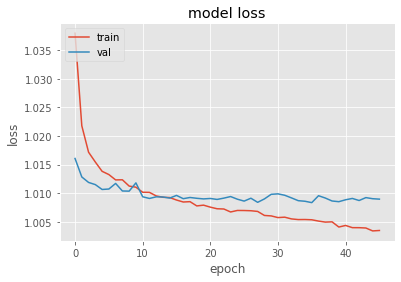

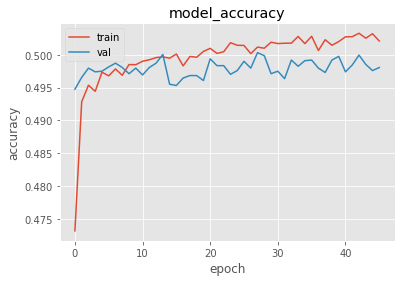

In [45]:
# history의 accuracy, loss 시각화
history_loss_acc(h)

### 모델 평가

In [46]:
def evaluate(model, X, y):
    probs = model.predict(X)
    preds = np.argmax(probs, axis=1)
    report = metrics.classification_report(y, preds)
    print(report)
    logloss = metrics.log_loss(y, probs)
    print('Log loss:', logloss)
    cm = metrics.confusion_matrix(y, preds)
    disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(target2int.keys()))
    disp.plot(cmap=plt.cm.Blues)
    plt.show();

              precision    recall  f1-score   support

           0       0.51      0.80      0.62      4543
           1       0.48      0.49      0.49      3370
           2       0.35      0.01      0.01      2672

    accuracy                           0.50     10585
   macro avg       0.45      0.43      0.37     10585
weighted avg       0.46      0.50      0.42     10585

Log loss: 1.0083484721996057


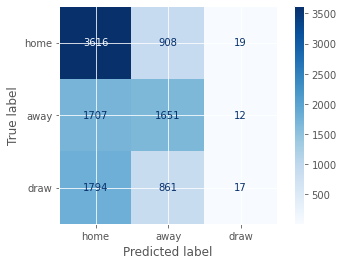

In [47]:
evaluate(model, X_val, y_val)

`draw`가 log loss 값에 악영향을 끼치는 것으로 보임

### 모델 예측

In [48]:
# home, away, draw
probs_test = model.predict(X_test)
probs_test

array([[0.45799455, 0.24609187, 0.29591352],
       [0.34591746, 0.35400116, 0.30008134],
       [0.29630905, 0.40238914, 0.30130187],
       ...,
       [0.09172068, 0.765275  , 0.14300433],
       [0.57643485, 0.17474304, 0.2488221 ],
       [0.34605697, 0.3702229 , 0.2837202 ]], dtype=float32)

In [49]:
# 열 출력 다시 원래 default로 설정
pd.reset_option('display.max_rows')

In [50]:
df_sub = pd.DataFrame({
    'id': test_df['id'],
    'home': probs_test[:, 0],
    'away': probs_test[:, 1],
    'draw': probs_test[:, 2]
})
df_sub

,id,home,away,draw
0,17761448,0.457995,0.246092,0.295914
1,17695487,0.345917,0.354001,0.300081
2,17715496,0.296309,0.402389,0.301302
3,17715493,0.175556,0.574131,0.250312
4,17715492,0.476357,0.216271,0.307373
...,...,...,...,...
72706,18450246,0.399983,0.300702,0.299315
72707,18164889,0.575650,0.171909,0.252441
72708,18449018,0.091721,0.765275,0.143004
72709,17958831,0.576435,0.174743,0.248822


In [51]:
pd.concat([
    train_df['target_int'].value_counts(normalize=True).sort_index().rename('observed'),
    pd.Series(np.argmax(df_sub.iloc[:, 1:].values, axis=1), name='predicted').value_counts(normalize=True).sort_index()
], axis=1)

,observed,predicted
0,0.433691,0.665993
1,0.317057,0.331119
2,0.249252,0.002888


observed와 predicted의 차이를 보면 home(0), away(1)에 비해 draw(2)를 확실히 더 잘 못 예측하는 것을 알 수 있음 

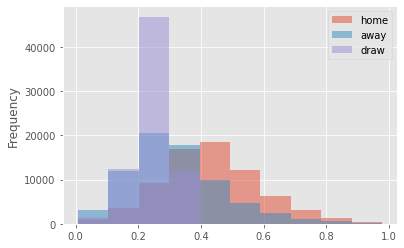

In [52]:
df_sub.iloc[:, 1:].plot.hist(alpha=0.5);

In [53]:
# submission expects this order: id, home, away, draw
df_sub[['id', 'home', 'away', 'draw']].to_csv('bi_lstm_prediction.csv', index=False)

In [54]:
!head bi_lstm_prediction.csv

id,home,away,draw
17761448,0.45799455,0.24609187,0.29591352
17695487,0.34591746,0.35400116,0.30008134
17715496,0.29630905,0.40238914,0.30130187
17715493,0.17555635,0.57413125,0.25031248
17715492,0.4763566,0.21627086,0.30737254
17715490,0.51558286,0.18452276,0.29989445
17709178,0.4759515,0.24406174,0.27998674
17948950,0.5933936,0.19219345,0.21441291
17948206,0.42157915,0.34191474,0.23650612


# END